In [1]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot') 
import numpy as np
import statsmodels.api as sm
import seaborn

In [2]:
data = pd.read_csv('us-counties.csv', parse_dates=[0])

counties_regions = pd.read_csv('counties-to-regions.csv', index_col=[0, 1]).region

data = data.assign(region=data.set_index(['county', 'state']).index.map(counties_regions))

In [3]:
N = 50
region_data = (pd.pivot_table(
    data,
    values='cases',
    columns='region',
    index='date',
    aggfunc=np.sum)
).stack().reset_index(1).rename(columns={0: 'cases'})
first_date = region_data[region_data.cases > N].reset_index().groupby('region').date.min()
last_date = region_data[region_data.cases > N].reset_index().groupby('region').date.max()
region_data = region_data.assign(days_since_start=region_data.index - region_data.region.map(first_date))


In [4]:
as_of = last_date.max() + pd.Timedelta(days=1)

In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = dict(zip(region_data.region.unique(), colors))

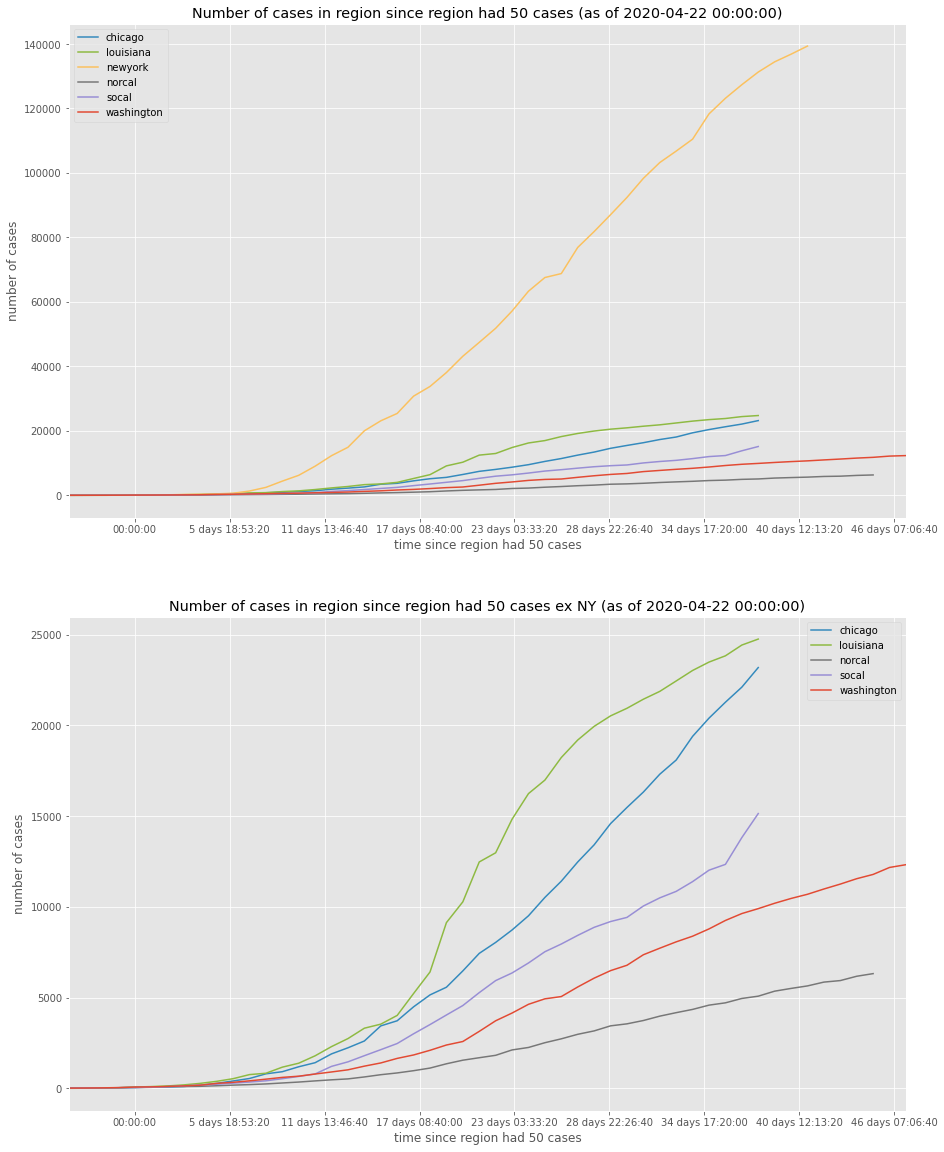

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 20), nrows=2)
for region, group in (region_data[region_data.days_since_start > '-5 days']
                      .set_index('days_since_start')
                      .groupby('region')):
    group.cases.plot(legend=True, ax=ax1, color=color_map[region], label=region)
#  .cases.plot(legend=True, ax=ax1))
ax1.set_title(f'Number of cases in region since region had {N} cases (as of {as_of})')
ax1.set_ylabel('number of cases')
ax1.set_xlabel(f'time since region had {N} cases')


for region, group in (region_data[(region_data.days_since_start > '-5 days') & (region_data.region != 'newyork')]
                     .set_index('days_since_start')
                     .groupby('region')):
    group.cases.plot(legend=True, ax=ax2, color=color_map[region], label=region)
ax2.set_title(f'Number of cases in region since region had {N} cases ex NY (as of {as_of})')
ax2.set_ylabel('number of cases')
ax2.set_xlabel(f'time since region had {N} cases')
fig.savefig('cases_in_region.png')



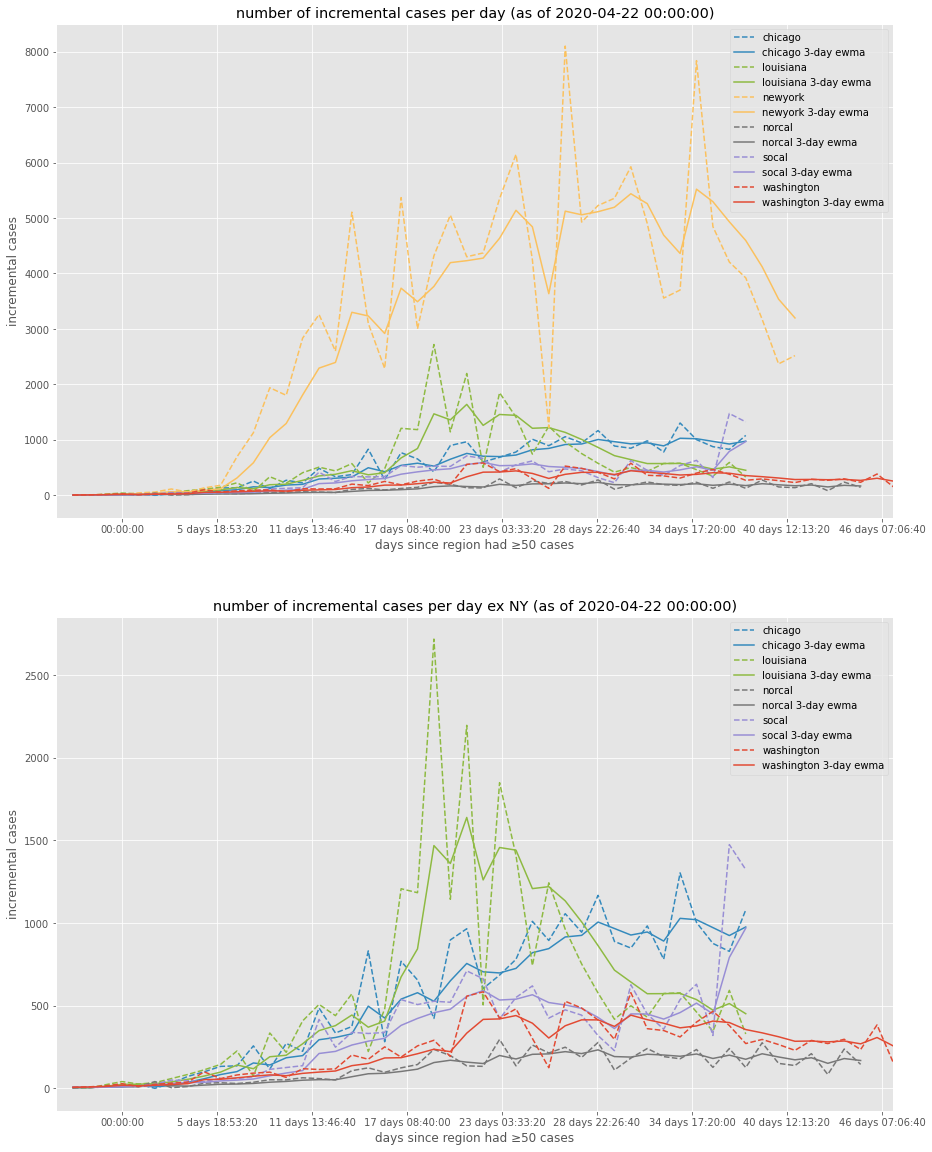

In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,20), nrows=2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = dict(zip(region_data.region.unique(), colors))
for region, group in (region_data[region_data.days_since_start > '-5 days']
                     .set_index('days_since_start')
                     .groupby('region')):
    diffs = group.cases.diff()
    res = diffs.plot(ax=ax1, label=region, color=color_map[region], style='--')
    diffs.ewm(span=5).mean().plot(ax=ax1, color=color_map[region], style='-', label=f'{region} 3-day ewma')
ax1.set_title(f'number of incremental cases per day (as of {as_of})')
ax1.set_ylabel('incremental cases')
ax1.set_xlabel(f'days since region had ≥{N} cases')
ax1.legend()

for color, (region, group) in zip(
    colors,
    region_data[(region_data.days_since_start > '-5 days') & (region_data.region != 'newyork')]
                     .set_index('days_since_start')
                     .groupby('region')):
    diffs = group.cases.diff()
    res = diffs.plot(ax=ax2, label=region, color=color_map[region], style='--')
    diffs.ewm(span=5).mean().plot(ax=ax2, color=color_map[region], style='-', label=f'{region} 3-day ewma')
ax2.set_title(f'number of incremental cases per day ex NY (as of {as_of})')
ax2.set_ylabel('incremental cases')
ax2.set_xlabel(f'days since region had ≥{N} cases')
ax2.legend()

fig.savefig('incremental-cases.png')

from datetime import date
norcal = region_data[region_data.region == 'norcal']

this = norcal.assign(ordinal=norcal.index.to_series().apply(lambda x: x.toordinal()))
# fig, ax = plt.subplots(figsize=(15, 10))
ax = seaborn.lmplot(data=this, x='ordinal', y='cases')
ax.set_xlabel('date')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

predict_x = pd.date_range(start=norcal.index.min(), end=norcal.index.max() + pd.Timedelta(days=10))
prediction = olsres.predict(sm.add_constant(pd.Series(predict_x.date).rank()))
prediction.index = predict_x
prediction.name = 'prediction'

fig, ax = plt.subplots()
norcal.cases.diff().plot(ax=ax)
prediction.plot(ax=ax)